In [ ]:
import tensorflow as tf

from transformers.keras_callbacks import KerasMetricCallback
from transformers import TFAutoModelForSequenceClassification
from transformers import create_optimizer
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
from transformers import pipeline
from transformers import AdamWeightDecay
from transformers import TFAutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from transformers.keras_callbacks import PushToHubCallback
from transformers import FSMTForConditionalGeneration, FSMTTokenizer

import numpy as np
import pandas as pd
from datasets import load_dataset
import evaluate

In [ ]:
devices = tf.config.experimental.list_physical_devices('GPU') if tf.test.is_gpu_available() else tf.config.experimental.list_physical_devices('CPU')
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.config.experimental.set_memory_growth(devices[0],True)

In [ ]:
pip install sacrebleu

Мы будем загружать модели на HuggingFace (их можно посмотреть тут: https://huggingface.co/rosenwild)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### Некоторые функции

In [ ]:
# Для задания 2

def preprocess_function(examples):
    return tokenizer(examples["review"], truncation=True)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
# Для задания 4

def preprocess_function_(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels


def compute_metrics_(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

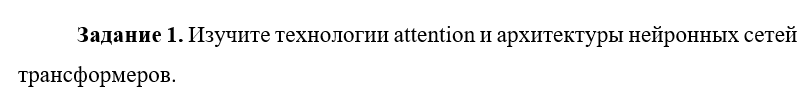
### Задание 1

In [ ]:
pip install transformers datasets evaluate

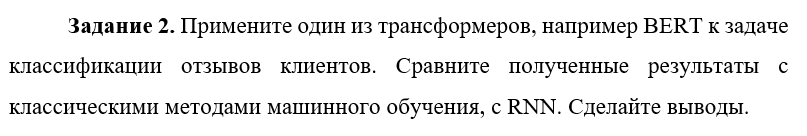
### Задание 2

#### Подготовка данных

Мы будем использовать для данного задания подготовленный и взятый из сервиса HuggingFace датасет на английском языке app reviews(https://huggingface.co/datasets/app_reviews), содержащий в себе отзывы на приложения и делящийся на следующие данные:
1. package name - название приложения, на который оставлен отзыв
2. review - сам отзыв
3. date - дата отзыва
4. star - данное количество звезд (от 1 до 5)\
\
Датасет имеет в себе 288065 строк, мы не будем уменьшать их количество, а только поделим выборку на обучающую и тестовую.

In [ ]:
reviews = load_dataset("app_reviews")

Generating train split:   0%|          | 0/288065 [00:00<?, ? examples/s]

In [ ]:
reviews

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 288065
    })
})

In [ ]:
reviews = reviews.remove_columns(['package_name', 'date'])
reviews  # мы удалили колонки с информацией о приложении и датой, ибо они бесполезны при обучении.

In [ ]:
splitted_reviews = reviews['train'].train_test_split(test_size=0.2, seed=42)
splitted_reviews

DatasetDict({
    train: Dataset({
        features: ['review', 'star'],
        num_rows: 230452
    })
    test: Dataset({
        features: ['review', 'star'],
        num_rows: 57613
    })
})

In [ ]:
splitted_reviews["train"][0]

{'review': 'Hated it', 'star': 1}

In [ ]:
df_train = pd.DataFrame(splitted_reviews['train'])
df_train.head()

,review,star
0,Hated it,1
1,Super,3
2,Memelay,5
3,It's a timer... I mean there's not much to sa...,5
4,Hummmmmmmmming....,3


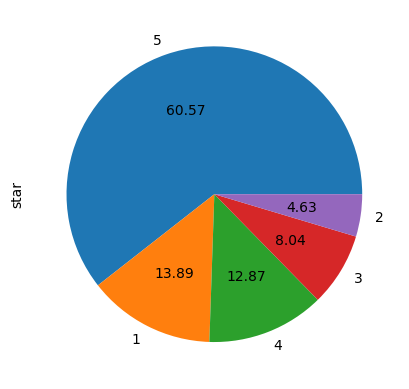

In [ ]:
ax = df_train["star"].value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("")

Хотя по диаграмме можно сказать, что данные несбалансированные, в силу их огромного количества нам хватит даже 4.63% (что составляет около 12000 отзывов) от общей выборки для идентифицирования "двух звезд".

#### Обучение

Для токенизации мы претрейновый токенизатор модели distilbert (ознакомиться можно по ссылке: https://huggingface.co/distilbert-base-uncased), которая, по сути, является очищенной и видоизмененной версией модели BERT.\
Data Collator необходим для разделения данных на батчи данных, к которым он применяет токенизатор.

In [ ]:
splitted_reviews = splitted_reviews.rename_column('star', 'label')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") # используем претрейновый токенизатор очищенной модели distilbert
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
accuracy = evaluate.load("accuracy")

In [ ]:
tokenized_reviews = splitted_reviews.map(preprocess_function, batched=True)

Map:   0%|          | 0/230452 [00:00<?, ? examples/s]

Map:   0%|          | 0/57613 [00:00<?, ? examples/s]

In [ ]:
batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_reviews["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

Для самого обучения мы также используем модель distilbert, упомянутый выше.

In [ ]:
ids_to_labels = {1:'☆', 2:'☆☆', 3:'☆☆☆', 4:'☆☆☆☆', 5:'☆☆☆☆☆'}
labels_to_ids = {'☆':1, '☆☆':2, '☆☆☆':3, '☆☆☆☆':4, '☆☆☆☆☆':5}
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=5,
    ids_to_labels=ids_to_labels,
    labels_to_ids=labels_to_ids)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
tf_train_set = model.prepare_tf_dataset( # tensorflow набор данных для трейна и теста на основе подготовленных данных
    tokenized_reviews["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_reviews["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

model.compile(optimizer=optimizer)
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set) # используем базовые коллбеки библиотеки Keras

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=metric_callback)

Epoch 1/3
14403/14403 [==============================] - 2435s 167ms/step - loss: nan - val_loss: nan - accuracy: 0.0000e+00
Epoch 2/3
14403/14403 [==============================] - 2185s 152ms/step - loss: nan - val_loss: nan - accuracy: 0.0000e+00
Epoch 3/3
14403/14403 [==============================] - 2185s 152ms/step - loss: nan - val_loss: nan - accuracy: 0.0000e+00


In [ ]:
model.push_to_hub('NLPLab5Task2', tokenizer=tokenizer)

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Без дообучения
review = ["It could be better, I really did not enjoyed it", "very bad", "Super good, I liked it"]
classifier = pipeline("sentiment-analysis", model='distilbert-base-uncased')
classifier(review)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'LABEL_1', 'score': 0.5167626738548279},
 {'label': 'LABEL_1', 'score': 0.5121874809265137},
 {'label': 'LABEL_1', 'score': 0.5267556309700012}]

In [ ]:
# После дообучения
review =["It could be better, I really did not enjoyed it", "very bad", "Super good, I liked it"]
classifier = pipeline("sentiment-analysis", model='rosenwild/NLPLab5Task2')
classifier(review)

config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': '☆☆☆☆☆', 'score': 0.6470399498939514},
 {'label': '☆', 'score': 0.5871496200561523},
 {'label': '☆☆☆☆☆', 'score': 0.8534325361251831}]

В силу большого количества данных (14403 батча по 16 элементов) 1 эпоха в среднем занимала 30 минут
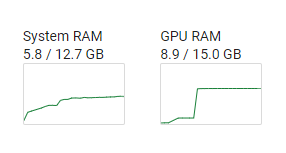

Однако в силу использования GPU и использования предобученной модели, она дала хорошие результаты

#### Выводы:

Сравнивая использование трансформеров и классические модели RNN (https://colab.research.google.com/drive/1bmnz-o5mTnRipRiGM9Cm5sMBN95bfSIi?usp=sharing) в задачах классификации, нужно учитывать, что есть свои плюсы и минусы. \
Использование трансформеров само по себе предполагает отсутствие надобности обучать модель с нуля или писать с нуля архитектуру модели, однако, в зависимости от целей работы, необходимо выделить надобность дообучения. \
Использованная модель destillbert отлично себя показала и выдала хороший результат на ручном тестировании, и, безусловно, у нее большое преимущество в количестве времени на дообучение. Но без дообучения она может дать непредвиденный результат.

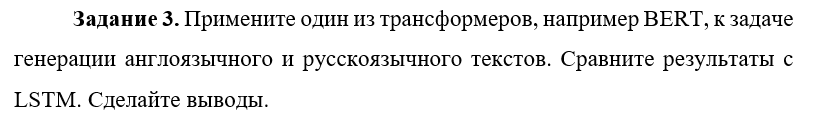
### Задание 3

Используем различные модели для генерации текста на разных языках
#### Английский: модель - gpt2

Для генерации текста на английском была взята **уменьшенная** модель gpt2 (авторами которой являются OpenAI), ознакомиться с которой можно по ссылке: https://huggingface.co/gpt2 \
Данная модель была натренирована на информации в открытом доступе из различных источников без контроля обучения со стороны "учителя".

In [ ]:
gen_en = pipeline('text-generation', model='gpt2')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
gen_en('Neural Network is', num_return_sequences = 3, max_length = 30)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Neural Network is a new approach and makes it possible to visualize our brain's visual regions as we move from one location to another, in the same"},
 {'generated_text': 'Neural Network is a high-performance neurocognitive approach that employs the key principles of quantum mechanics, a technique of building a neural network that integrates'},
 {'generated_text': 'Neural Network is made up of the same types of neural networks and its connectivity with specific cells. The most recent findings may lead to the first demonstration'}]

#### Русский: модель ru-gpt2

Для генерации текста на русском языке была взята **уменьшенная** модель rugpt3, которая базируется на gpt2 (использована выше), ознакомиться можно по ссылкам:\
https://huggingface.co/ai-forever/rugpt3medium_based_on_gpt2 \
https://arxiv.org/abs/2309.10931 \
Модель была обучена командой SberDevices.

In [ ]:
gen_ru = pipeline('text-generation', model='ai-forever/rugpt3medium_based_on_gpt2')

In [ ]:
gen_ru('Нейронная сеть - это',)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Нейронная сеть - это не просто набор нейронов, это система, которая может быть использована'}]

Сравнивая генерацию текста с помощью трансформеров и с помощью классических задач машинного обучения (LSTM: https://colab.research.google.com/drive/1KGYjMc4zar8nsm1ibQKqrHtG8LyoK0Mb?usp=sharing), можно отметить, что использование существующих моделей имеет огромные плюсы: чтобы использовать ее, нужно только импортировать, и при необходимости дообучить на своем наборе текста. А главную проблему генерации с помощью LSTM на созданной тобой архитектуре модель отсекает - у трансформера огромный словарь, и нет необходимости бояться за генерацию несуществующих слов.

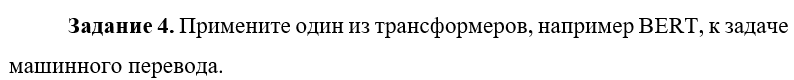
### Задание 4

Для данного задания используется предобученная модель wmt19-en-ru, ознакомиться можно по ссылкам:\
https://huggingface.co/facebook/wmt19-en-ru \
https://arxiv.org/abs/1907.06616

In [ ]:
pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 10.1 MB/s eta 0:00:00


In [ ]:
mname = "facebook/wmt19-en-ru"
tokenizer = FSMTTokenizer.from_pretrained(mname)
model = FSMTForConditionalGeneration.from_pretrained(mname)

pytorch_model.bin:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-en-ru and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [ ]:
input = "Machine learning is great, isn't it?"
input_ids = tokenizer.encode(input, return_tensors="pt")
outputs = model.generate(input_ids)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded)

Машинное обучение - это здорово, не так ли?
